In [56]:
import pandas as pd
import numpy as np

from wordcloud import WordCloud

import isodate
import ast
import re
from unidecode import unidecode

import emoji
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from bertopic import BERTopic




# Import necessary libraries to visualize data
import matplotlib.pyplot as plt
import seaborn as sns


# Import necessary libraries for data selection
from sklearn.feature_selection import chi2

# Import library for data splitting
from sklearn.model_selection import train_test_split

# Import necessary libraries for data modelling
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor, Pool

from sklearn.metrics import make_scorer, r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
import shap

In [150]:
df = pd.read_csv('new_programming_org.csv', parse_dates=['fetching_date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2408 entries, 0 to 2407
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   fetching_date         2408 non-null   datetime64[ns]
 1   trending_country      2408 non-null   object        
 2   video_id              2408 non-null   object        
 3   video_title           2408 non-null   object        
 4   video_published_at    2408 non-null   object        
 5   video_description     1770 non-null   object        
 6   channel_id            2408 non-null   object        
 7   channel_title         2408 non-null   object        
 8   tags                  2408 non-null   object        
 9   category_id           2408 non-null   int64         
 10  default_language      2408 non-null   object        
 11  duration              2408 non-null   object        
 12  dimension             2408 non-null   object        
 13  definition        

In [151]:
def extract_topics(text):
    if not isinstance(text, str):
        return ''
    topics = re.findall(r'wiki/([^\'",\]]+)', text)
    return ', '.join(topics)

df['topic_categories'] = df['topic_categories'].apply(extract_topics)


In [59]:
def data_cleaning(df):
    # Remove duplicates
    hashable_cols = [col for col in df.columns if col not in ['tags', 'topic_categories']]
    df_clean = df.drop_duplicates(subset=hashable_cols)

    # Handle missing values
    key_columns = [
                    'video_id',
                    'video_title', 
                    'video_view_count', 
                    'video_like_count', 
                    'video_comment_count',
                    'video_count', 
                    'subscriber_count', 
                    'channel_view_count'
                ]
    df_clean = df_clean.dropna(subset=key_columns)

    # Remove entries with zero video_count, video_view_count, or channel_view_count
    df_clean = df_clean[(df_clean['video_count'] != 0) & (df_clean['video_view_count'] != 0) & (df_clean['channel_view_count'] != 0)]

    # Filter for English language videos
    df_clean = df_clean[df_clean['default_language'].str.startswith('en', na=False)]

    # Map category_id to category_title
    category_map = {
                    '1': 'Film & Animation',
                    '2': 'Autos & Vehicles',
                    '10': 'Music',
                    '15': 'Pets & Animals',
                    '17': 'Sports',
                    '18': 'Short Movies',
                    '19': 'Travel & Events',
                    '20': 'Gaming',
                    '21': 'Videoblogging',
                    '22': 'People & Blogs',
                    '23': 'Comedy',
                    '24': 'Entertainment',
                    '25': 'News & Politics',
                    '26': 'Howto & Style',
                    '27': 'Education',
                    '28': 'Science & Technology',
                    '29': 'Nonprofits & Activism',
                    '30': 'Movies',
                    '31': 'Anime/Animation',
                    '32': 'Action/Adventure',
                    '33': 'Classics',
                    '34': 'Comedy',
                    '35': 'Documentary',
                    '36': 'Drama',
                    '37': 'Family',
                    '38': 'Foreign',
                    '39': 'Horror',
                    '40': 'Sci-Fi/Fantasy',
                    '41': 'Thriller',
                    '42': 'Shorts',
                    '43': 'Shows',
                    '44': 'Trailers'
                    }   

    # Process duration and category   
    df_clean['category_title'] = df_clean['category_id'].apply(lambda x: category_map[str(x)])
    # df_clean['duration_min'] = df_clean['duration'].apply(
    #     lambda x: isodate.parse_duration(x).total_seconds()/60)
    # df_clean['is_high_definition'] = df_clean['definition'].apply(lambda x: 1 if x == 'hd' else 0)

    # Convert date columns to datetime
    df_clean['video_published_at'] = pd.to_datetime(df_clean['video_published_at'])
    df_clean['channel_published_at'] = df_clean['channel_published_at'].apply(lambda x: re.sub(r'\.\d+Z', 'Z', str(x)))
    df_clean['channel_published_at'] = pd.to_datetime(df_clean['channel_published_at']) 
    

    return df_clean

In [60]:
def normalize_text(text):
    if pd.isna(text):
        return ''
    
    # Convert to lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    #  Remove Web links
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def additional_normalize_text(text):
    if pd.isna(text):
        return ''
    
    # Convert accented characters to their ASCII equivalents
    text = unidecode(text)
    # Remove special characters and punctuation
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def normalize_text_columns(df, function=normalize_text):
    text_columns = ['video_title', 'video_description', 'channel_title', 'channel_description']
    for col in text_columns:
        df[col] = df[col].apply(function)
    return df

In [61]:
def sentiment_enginering(df):
    analyzer = SentimentIntensityAnalyzer()
    sentiment_columns = ['video_title', 'video_description']
    for col in sentiment_columns:
        df[f'{col}_sentiment'] = df[col].apply(lambda x: analyzer.polarity_scores(x)["compound"])
        # df[f'has_emoji_in_{col}'] = df[col].apply(lambda x: 1 if any(char in emoji.EMOJI_DATA for char in x) else 0)
        df[f'count_of_emoji_in_{col}'] = df[col].apply(lambda x: sum(1 for char in x if char in emoji.EMOJI_DATA)) 
    return df

In [84]:
def model_feature_engineering(df):

    df['publishing_day'] = df['video_published_at'].apply(lambda x: pd.to_datetime(x).day_name())
    df['publishing_hour'] = df['video_published_at'].apply(lambda x: pd.to_datetime(x).hour)
    
    df['video_age_days'] = (pd.to_datetime(df['fetching_date'], utc=True) - pd.to_datetime(df['video_published_at'])).dt.total_seconds() / (24 * 3600)  
    df['channel_age_days'] = (pd.to_datetime(df['fetching_date'], utc=True) - pd.to_datetime(df['channel_published_at'])).dt.total_seconds() / (24 * 3600)  

    # df['has_tags'] = df['tags'].apply(lambda x: 0 if pd.isna(x) or x.strip() == '[]' else 1)
    df['counts_of_tags'] = df['tags'].apply(lambda x: 0 if pd.isna(x) else len(ast.literal_eval(x)))
    # df['has_topic_categories'] = df['topic_categories'].apply(lambda x: 0 if pd.isna(x) or x.strip() == '' else 1)
    # df['counts_of_topic_categories'] = df['topic_categories'].apply(lambda x: 0 if pd.isna(x) else len(ast.literal_eval(x)))
    # df['has_video_description'] = df['video_description'].apply(lambda x: 0 if pd.isna(x) or x.strip() == '' else 1)
    # df['has_channel_description'] = df['channel_description'].apply(lambda x: 0 if pd.isna(x) or x.strip() == '' else 1)    
    df['word_count_in_title'] = df['video_title'].apply(lambda x: len(x.split()))
    df['word_count_in_description'] = df['video_description'].apply(lambda x: 0 if pd.isna(x) or x.strip() == '' else len(x.split()))
    df['word_count_in_channel_title'] = df['channel_title'].apply(lambda x: len(x.split())) 
    df['word_count_in_channel_description'] = df['channel_description'].apply(lambda x: 0 if pd.isna(x) or x.strip() == '' else len(x.split()))
    # df['character_count_in_title'] = df['video_title'].apply(lambda x: len(x))
    # df['character_count_in_description'] = df['video_description'].apply(lambda x: 0 if pd.isna(x) or x.strip() == '' else len(x))
    

    # df['title_sentiment_blob'] = df['video_title'].apply(lambda x: TextBlob(x).sentiment.polarity)
    # df['description_sentiment_blob'] = df['video_description'].apply(lambda x: 0 if pd.isna(x) or x.strip() == '' else TextBlob(x).sentiment.polarity)
    df['engagement_rate'] = (df['video_like_count'] + df['video_comment_count']) / df['video_view_count']
    df['avg_weekly_posts'] = (df['video_count'] / df['channel_age_days'])*7

    return df


In [152]:
df.isnull().sum()
df = df.dropna(subset=['duration'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2408 entries, 0 to 2407
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   fetching_date         2408 non-null   datetime64[ns]
 1   trending_country      2408 non-null   object        
 2   video_id              2408 non-null   object        
 3   video_title           2408 non-null   object        
 4   video_published_at    2408 non-null   object        
 5   video_description     1770 non-null   object        
 6   channel_id            2408 non-null   object        
 7   channel_title         2408 non-null   object        
 8   tags                  2408 non-null   object        
 9   category_id           2408 non-null   int64         
 10  default_language      2408 non-null   object        
 11  duration              2408 non-null   object        
 12  dimension             2408 non-null   object        
 13  definition        

In [153]:
df = data_cleaning(df)
df = normalize_text_columns(df, function=normalize_text)
df = sentiment_enginering(df)
df = normalize_text_columns(df, function=additional_normalize_text)
dfoo = df.copy()
df = model_feature_engineering(df)

df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2153 entries, 0 to 2407
Data columns (total 43 columns):
 #   Column                               Non-Null Count  Dtype              
---  ------                               --------------  -----              
 0   fetching_date                        2153 non-null   datetime64[ns]     
 1   trending_country                     2153 non-null   object             
 2   video_id                             2153 non-null   object             
 3   video_title                          2153 non-null   object             
 4   video_published_at                   2153 non-null   datetime64[ns, UTC]
 5   video_description                    2153 non-null   object             
 6   channel_id                           2153 non-null   object             
 7   channel_title                        2153 non-null   object             
 8   tags                                 2153 non-null   object             
 9   category_id                        

EDA

<Axes: >

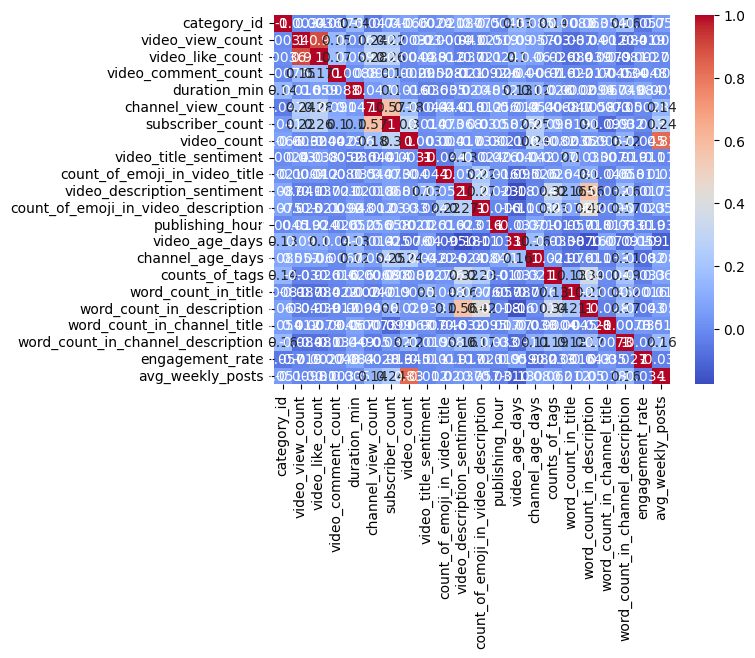

In [67]:
# heatmap for correlation
numeric_cols = df.select_dtypes(include='number').columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')


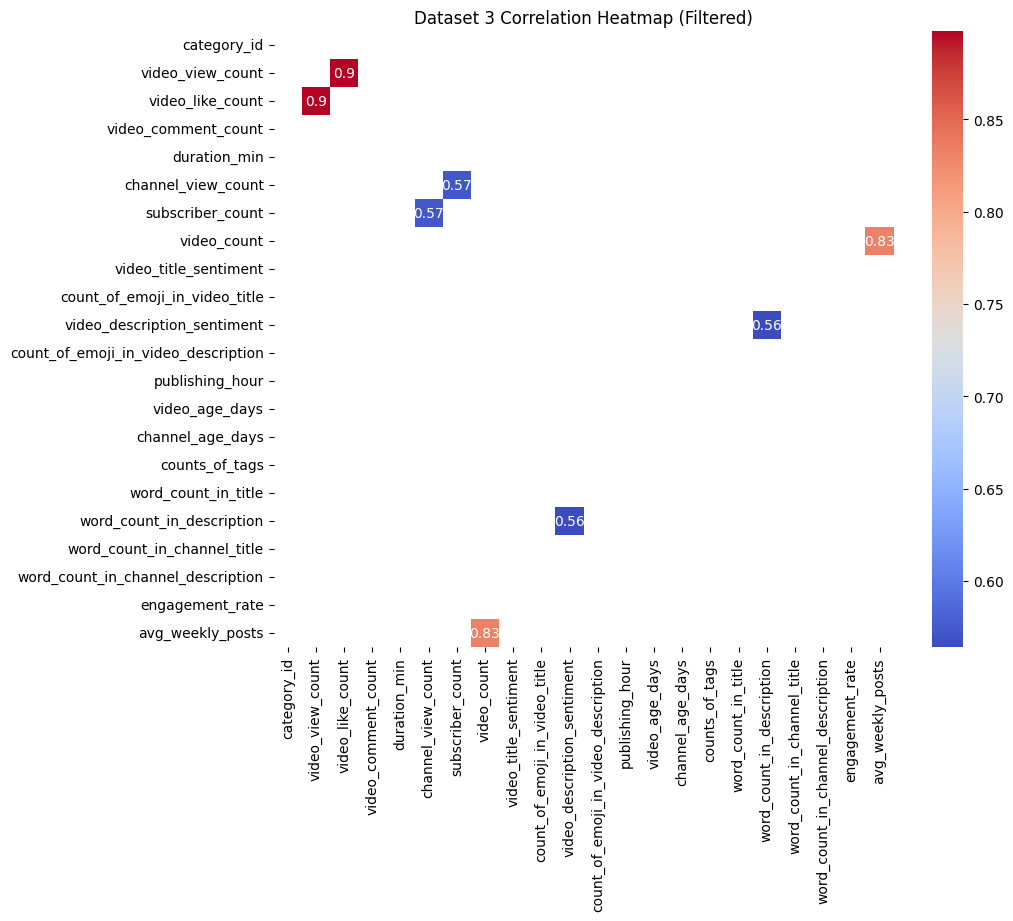

In [68]:
filtered_heatmap = df[numeric_cols].corr().abs()
filtered_heatmap = (filtered_heatmap > 0.5) & (filtered_heatmap < 1.0)
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', mask=~filtered_heatmap)
plt.title('Dataset 3 Correlation Heatmap (Filtered)')
plt.show()  

In [69]:
df.describe()

,fetching_date,category_id,video_view_count,video_like_count,video_comment_count,duration_min,channel_view_count,subscriber_count,video_count,video_title_sentiment,...,publishing_hour,video_age_days,channel_age_days,counts_of_tags,word_count_in_title,word_count_in_description,word_count_in_channel_title,word_count_in_channel_description,engagement_rate,avg_weekly_posts
count,2153,2153.000000,2.153000e+03,2.153000e+03,2153.000000,2153.000000,2.153000e+03,2.153000e+03,2153.000000,2153.000000,...,2153.000000,2153.000000,2153.000000,2153.000000,2153.000000,2153.000000,2153.000000,2153.000000,2153.000000,2153.000000
mean,2025-11-09 10:47:38.100173312,25.395262,8.046468e+05,2.806159e+04,564.760334,0.606007,1.808990e+08,5.999175e+05,1358.425453,0.064064,...,11.196935,484.588921,1916.017930,7.660938,9.177427,77.725499,2.173247,68.540176,0.046669,4.150618
min,2025-11-09 10:47:38.100173,1.000000,1.000000e+00,0.000000e+00,0.000000,0.033333,2.000000e+00,0.000000e+00,1.000000,-0.953100,...,0.000000,-0.243795,0.636355,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.004063
25%,2025-11-09 10:47:38.100173056,22.000000,1.780000e+02,6.000000e+00,0.000000,0.316667,4.246100e+04,2.050000e+02,67.000000,0.000000,...,7.000000,193.371668,795.850383,0.000000,7.000000,0.000000,1.000000,18.000000,0.015625,0.443774
50%,2025-11-09 10:47:38.100173056,27.000000,2.051000e+03,5.300000e+01,2.000000,0.616667,4.842660e+05,2.350000e+03,228.000000,0.000000,...,12.000000,466.836413,1458.728508,0.000000,9.000000,38.000000,2.000000,70.000000,0.027741,1.303882
75%,2025-11-09 10:47:38.100173056,27.000000,1.974230e+05,4.327000e+03,37.000000,0.916667,1.177872e+07,6.790000e+04,706.000000,0.000000,...,15.000000,772.657756,2896.569249,15.000000,11.000000,109.000000,3.000000,113.000000,0.048052,3.511046
max,2025-11-09 10:47:38.100173,29.000000,1.549867e+08,6.436432e+06,809987.000000,1.000000,5.444482e+10,3.760000e+07,177265.000000,0.921700,...,23.000000,1041.605997,7342.778497,66.000000,19.000000,841.000000,8.000000,251.000000,1.000000,203.448543
std,NaN,3.907304,5.969754e+06,2.154249e+05,17504.771755,0.300525,1.910518e+09,2.464129e+06,6835.964394,0.236250,...,5.339692,324.656609,1540.033704,10.445212,3.013925,110.553417,1.041959,49.847755,0.079434,12.573594


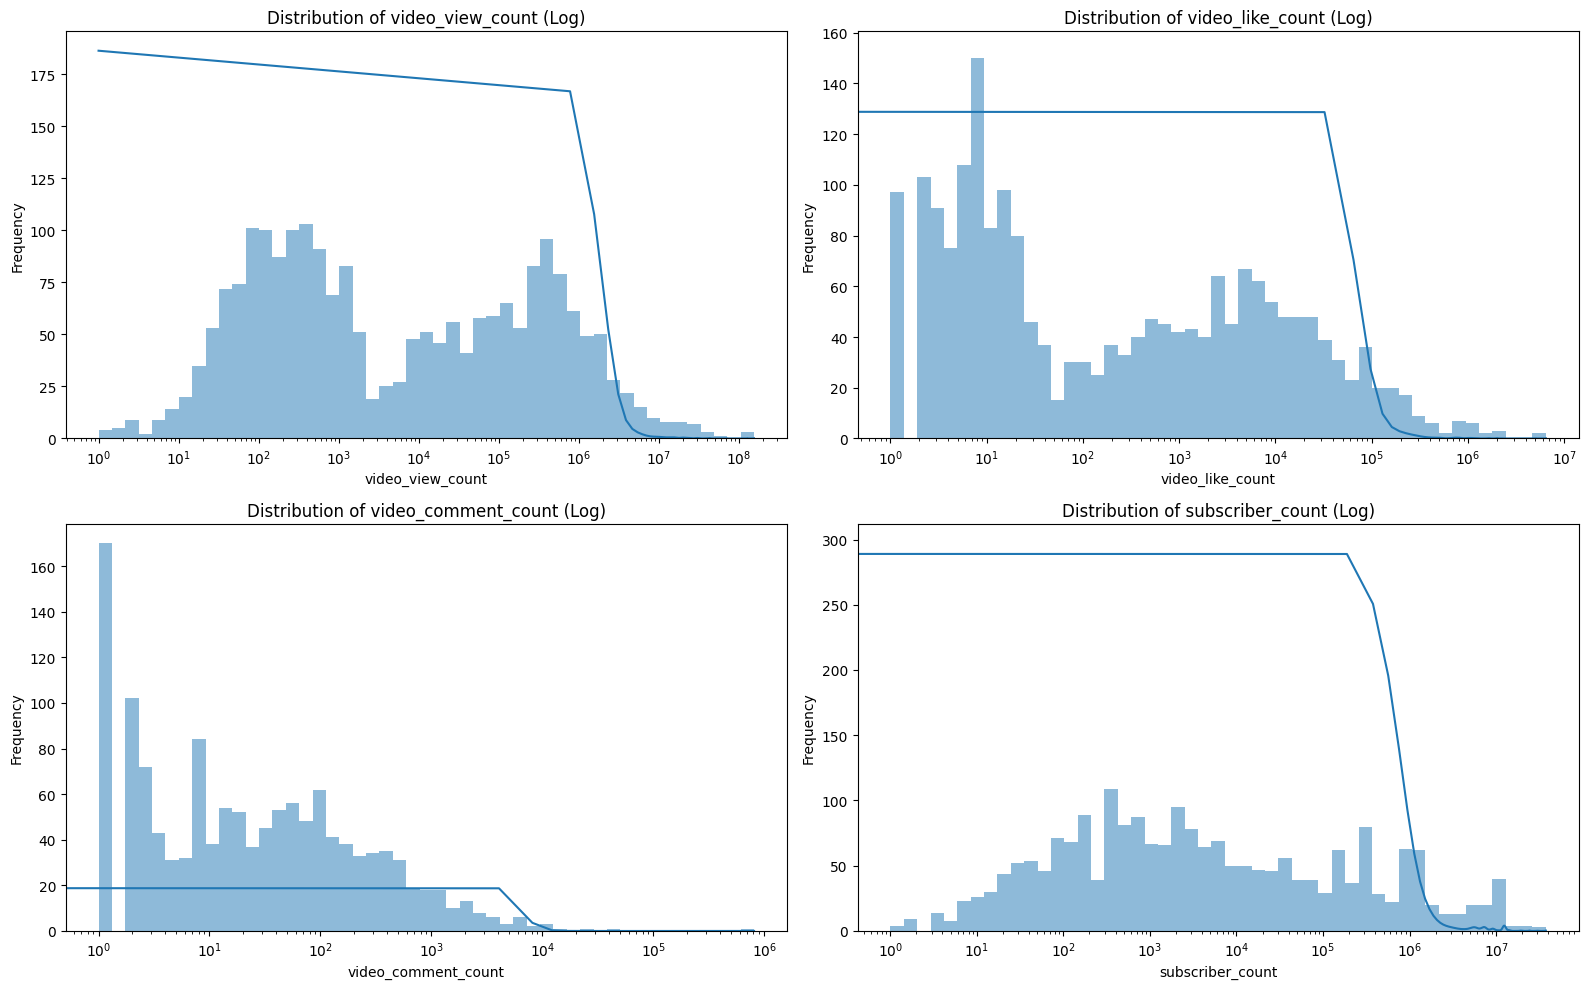

In [70]:
cols = ['video_view_count', 'video_like_count', 'video_comment_count', 'subscriber_count']

# Set up the figure
plt.figure(figsize=(16, 10))

for i, col in enumerate(cols, 1):
    plt.subplot(2, 2, i)
    
    # Logarithmic binning
    bins = np.logspace(0, np.log10(df[col].max()+1), 50)  # add 1 to avoid log(0)
    
    sns.histplot(df[col], bins=bins, kde=True)
    plt.xscale('log')
    plt.title(f'Distribution of {col} (Log)')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



In [71]:
plt.figure(figsize=(8,5))
sns.boxplot(x='publishing_day', y=np.log10(dfo['video_view_count']), data=dfo)
plt.title("Video Views(Log) by Publishing Day")
plt.ylabel("Views")
plt.xlabel("Publishing Day")
plt.show()

NameError: name 'dfo' is not defined

<Figure size 800x500 with 0 Axes>

/Users/meilan/neuMSDAE/myenv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


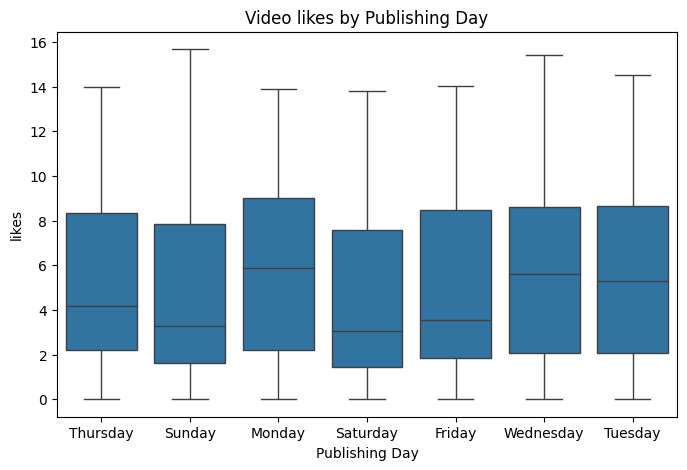

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='publishing_day', y=np.log(dfo['video_like_count']), data=dfo)
plt.title("Video likes by Publishing Day")
plt.ylabel("likes")
plt.xlabel("Publishing Day")
plt.show()

/Users/meilan/neuMSDAE/myenv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


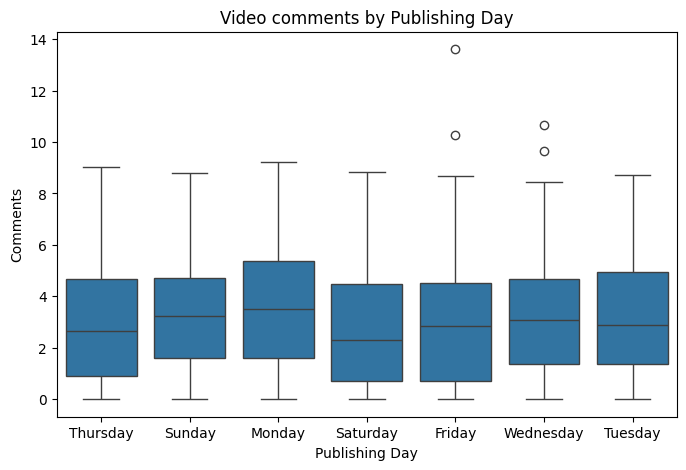

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='publishing_day', y=np.log(dfo['video_comment_count']), data=dfo)
plt.title("Video comments by Publishing Day")
plt.ylabel("Comments")
plt.xlabel("Publishing Day")
plt.show()

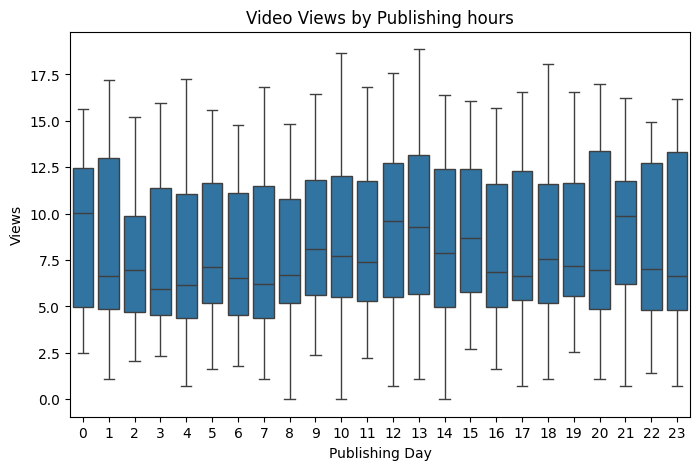

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='publishing_hour', y=np.log(dfo['video_view_count']), data=dfo)
plt.title("Video Views by Publishing hours")
plt.ylabel("Views")
plt.xlabel("Publishing Day")
plt.show()

/Users/meilan/neuMSDAE/myenv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


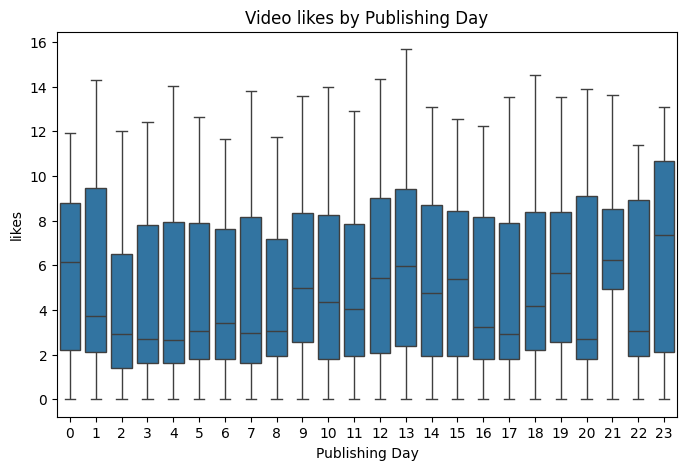

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='publishing_hour', y=np.log(dfo['video_like_count']), data=dfo)
plt.title("Video likes by Publishing Day")
plt.ylabel("likes")
plt.xlabel("Publishing Day")
plt.show()

/Users/meilan/neuMSDAE/myenv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


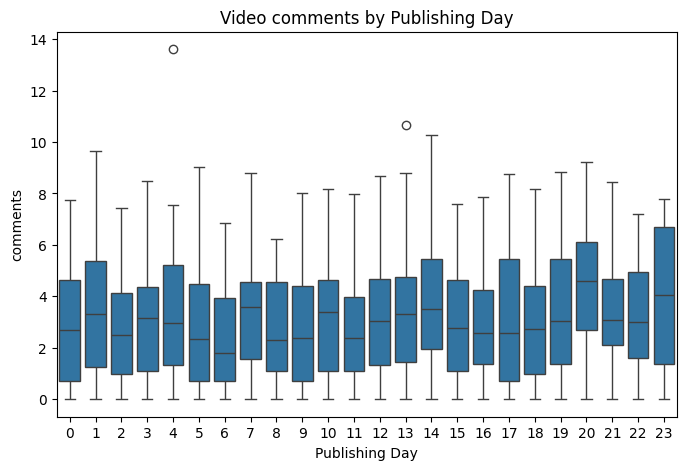

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='publishing_hour', y=np.log(dfo['video_comment_count']), data=dfo)
plt.title("Video comments by Publishing Day")
plt.ylabel("comments")
plt.xlabel("Publishing Day")
plt.show()

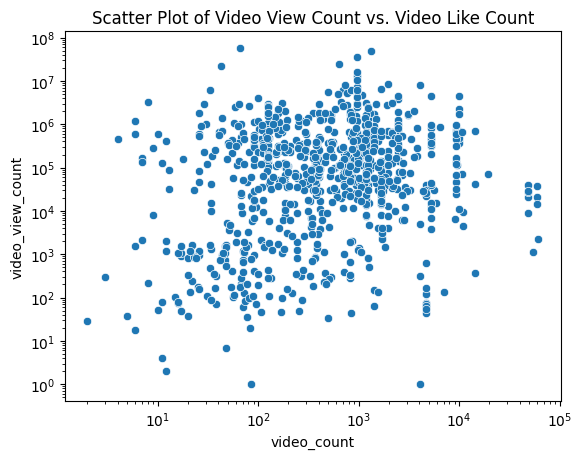

In [ ]:
sns.scatterplot(y='video_view_count', x='video_count', data=df)
plt.xscale('log')
plt.yscale('log')
# plt.xlabel('Video View Count (log scale)')
# plt.ylabel('Video Like Count (log scale)')
plt.title('Scatter Plot of Video View Count vs. Video Like Count')
plt.show()


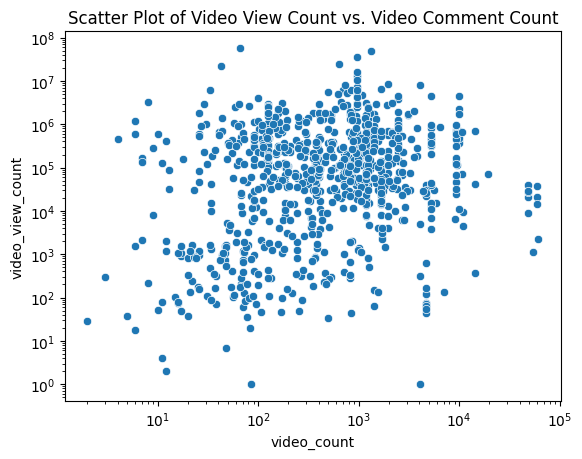

In [ ]:
sns.scatterplot(y='video_view_count', x='video_count', data=dfo)
plt.xscale('log')
plt.yscale('log')
# plt.xlabel('Video View Count (log scale)')
# plt.ylabel('Video Comment Count (log scale)')
plt.title('Scatter Plot of Video View Count vs. Video Comment Count')
plt.show()               

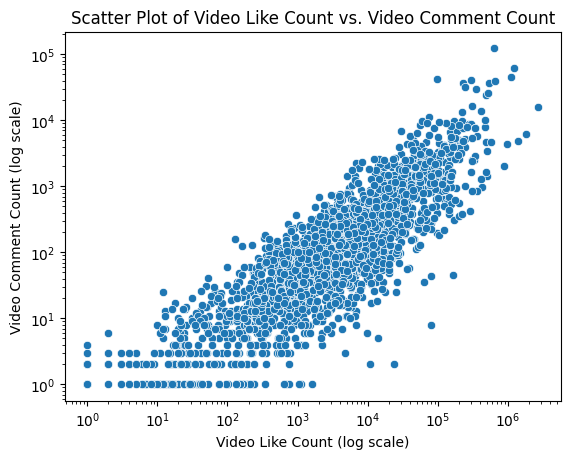

In [ ]:
sns.scatterplot(x='video_like_count', y='video_comment_count', data=dfo)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Video Like Count (log scale)')
plt.ylabel('Video Comment Count (log scale)')
plt.title('Scatter Plot of Video Like Count vs. Video Comment Count')
plt.show()




In [ ]:
threshold = df['video_view_count'].quantile(0.50)
top_videos = df[df['video_view_count'] >= threshold]
top_videos.describe()

,fetching_date,category_id,licensed_content,video_view_count,video_like_count,video_comment_count,made_for_kids,duration_min,channel_view_count,subscriber_count,...,publishing_hour_14,publishing_hour_15,publishing_hour_16,publishing_hour_17,publishing_hour_18,publishing_hour_19,publishing_hour_20,publishing_hour_21,publishing_hour_22,publishing_hour_23
count,1077,1077.000000,1077.000000,1.077000e+03,1.077000e+03,1077.000000,1077.000000,1077.000000,1.077000e+03,1.077000e+03,...,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000
mean,2025-11-09 10:47:38.100173312,26.046425,0.578459,1.608173e+06,5.608674e+04,1128.274838,0.003714,0.621882,3.583886e+08,1.181854e+06,...,0.083565,0.077066,0.048282,0.040854,0.030641,0.021356,0.008357,0.025998,0.011142,0.012999
min,2025-11-09 10:47:38.100173,1.000000,0.000000,2.051000e+03,9.000000e+00,0.000000,0.000000,0.066667,3.869000e+03,1.100000e+01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2025-11-09 10:47:38.100173056,27.000000,0.000000,3.105000e+04,7.190000e+02,7.000000,0.000000,0.316667,9.916510e+05,3.810000e+03,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2025-11-09 10:47:38.100173056,27.000000,1.000000,1.974230e+05,4.327000e+03,37.000000,0.000000,0.683333,8.908097e+06,5.600000e+04,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2025-11-09 10:47:38.100173056,27.000000,1.000000,6.912900e+05,2.092900e+04,158.000000,0.000000,0.933333,9.077596e+07,5.340000e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2025-11-09 10:47:38.100173,28.000000,1.000000,1.549867e+08,6.436432e+06,809987.000000,1.000000,1.000000,5.444482e+10,3.760000e+07,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,NaN,2.702002,0.494035,8.365573e+06,3.020642e+05,24742.636925,0.060858,0.312601,2.690086e+09,3.384360e+06,...,0.276864,0.266820,0.214462,0.198044,0.172422,0.144634,0.091074,0.159204,0.105015,0.113323


In [ ]:
dfo.columns

Index(['video_id', 'fetching_date', 'trending_country', 'video_title',
       'video_published_at', 'video_description', 'channel_id',
       'channel_title', 'tags', 'category_id', 'default_language', 'duration',
       'dimension', 'definition', 'licensed_content', 'video_view_count',
       'video_like_count', 'video_comment_count', 'topic_categories',
       'made_for_kids', 'channel_published_at', 'channel_description',
       'channel_country', 'channel_view_count', 'subscriber_count',
       'video_count', 'category_title', 'duration_min', 'is_high_definition',
       'video_title_sentiment', 'count_of_emoji_in_video_title',
       'video_description_sentiment', 'count_of_emoji_in_video_description',
       'publishing_day', 'publishing_hour', 'video_age_days',
       'channel_age_days', 'counts_of_tags', 'word_count_in_title',
       'word_count_in_description', 'word_count_in_channel_title',
       'word_count_in_channel_description'],
      dtype='object')

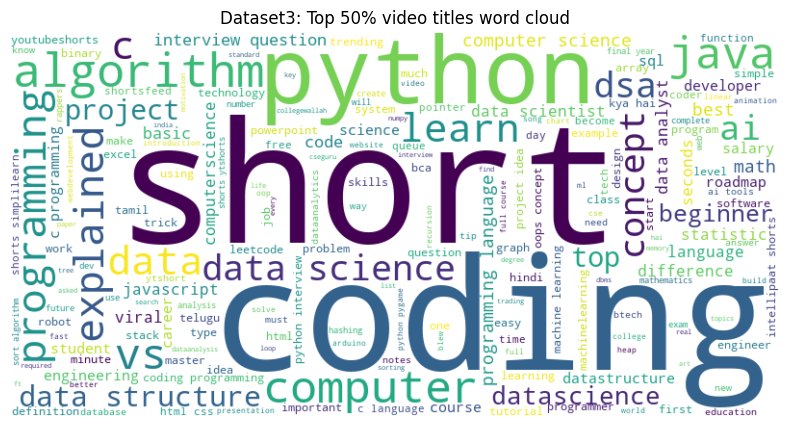

In [ ]:
text = ' '.join(top_videos['video_title'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.title('Dataset3: Top 50% video titles word cloud')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

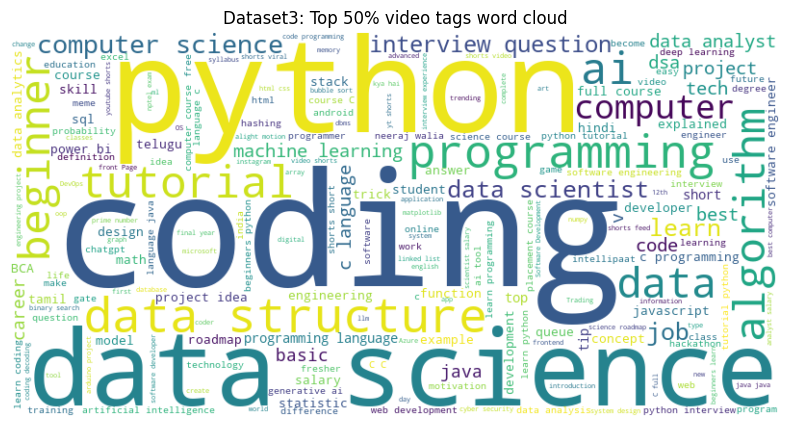

In [ ]:
all_tags = ' '.join(top_videos['tags'].dropna().apply(lambda x: ' '.join(ast.literal_eval(x))))
wordcloud_tags = WordCloud(width=800, height=400, background_color='white').generate(all_tags)
plt.figure(figsize=(10, 5))
plt.title('Dataset3: Top 50% video tags word cloud')
plt.imshow(wordcloud_tags, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
df.columns

Index(['fetching_date', 'trending_country', 'video_id', 'video_title',
       'video_published_at', 'video_description', 'channel_id',
       'channel_title', 'tags', 'category_id', 'default_language', 'duration',
       'dimension', 'definition', 'licensed_content', 'video_view_count',
       'video_like_count', 'video_comment_count', 'topic_categories',
       'made_for_kids', 'duration_min', 'channel_published_at',
       'channel_description', 'channel_country', 'channel_view_count',
       'subscriber_count', 'video_count', 'category_title',
       'video_title_sentiment', 'count_of_emoji_in_video_title',
       'video_description_sentiment', 'count_of_emoji_in_video_description',
       'publishing_day', 'publishing_hour', 'video_age_days',
       'channel_age_days', 'counts_of_tags', 'word_count_in_title',
       'word_count_in_description', 'word_count_in_channel_title',
       'word_count_in_channel_description'],
      dtype='object')

In [155]:
metrics = ['video_view_count', 'video_like_count', 'video_comment_count','channel_view_count', 'subscriber_count']
for metric in metrics:
    df[f'{metric}_log'] = np.log1p(df[metric])
df.columns

Index(['fetching_date', 'trending_country', 'video_id', 'video_title',
       'video_published_at', 'video_description', 'channel_id',
       'channel_title', 'tags', 'category_id', 'default_language', 'duration',
       'dimension', 'definition', 'licensed_content', 'video_view_count',
       'video_like_count', 'video_comment_count', 'topic_categories',
       'made_for_kids', 'duration_min', 'channel_published_at',
       'channel_description', 'channel_country', 'channel_view_count',
       'subscriber_count', 'video_count', 'category_title',
       'video_title_sentiment', 'count_of_emoji_in_video_title',
       'video_description_sentiment', 'count_of_emoji_in_video_description',
       'publishing_day', 'publishing_hour', 'video_age_days',
       'channel_age_days', 'counts_of_tags', 'word_count_in_title',
       'word_count_in_description', 'word_count_in_channel_title',
       'word_count_in_channel_description', 'engagement_rate',
       'avg_weekly_posts', 'video_view_count_

In [156]:
df_model = df[[ 'licensed_content',  'topic_categories',
       'made_for_kids', 'duration_min', 'video_count', 'category_title',
       'video_title_sentiment', 'count_of_emoji_in_video_title',
       'video_description_sentiment', 'count_of_emoji_in_video_description',
       'publishing_day', 'publishing_hour', 'video_age_days',
       'channel_age_days', 'counts_of_tags', 'word_count_in_title',
       'word_count_in_description', 'word_count_in_channel_title','engagement_rate','avg_weekly_posts',
       'word_count_in_channel_description', 'video_view_count_log',
       'video_like_count_log', 'video_comment_count_log',
       'channel_view_count_log', 'subscriber_count_log']]
len(df_model.columns)

26

In [157]:
output_cols =[
 'video_view_count_log', 'video_like_count_log',
       'video_comment_count_log',
    # 'channel_view_count_log',
    #    'subscriber_count_log'
]
df_output = df[output_cols]

In [ ]:
df_model.describe()

,duration_min,channel_view_count,subscriber_count,video_count,video_title_sentiment,count_of_emoji_in_video_title,video_description_sentiment,count_of_emoji_in_video_description,publishing_hour,video_age_days,...,word_count_in_description,word_count_in_channel_title,engagement_rate,avg_weekly_posts,word_count_in_channel_description,video_view_count_log,video_like_count_log,video_comment_count_log,channel_view_count_log,subscriber_count_log
count,2153.000000,2.153000e+03,2.153000e+03,2153.000000,2153.000000,2153.000000,2153.000000,2153.000000,2153.000000,2153.000000,...,2153.000000,2153.000000,2153.000000,2153.000000,2153.000000,2153.000000,2153.000000,2153.000000,2153.000000,2153.000000
mean,0.606007,1.808990e+08,5.999175e+05,1358.425453,0.064064,0.271714,0.383890,1.963307,11.196935,484.588921,...,77.725499,2.173247,0.046669,4.150618,68.540176,8.561176,5.105723,1.993432,13.426931,8.263429
std,0.300525,1.910518e+09,2.464129e+06,6835.964394,0.236250,0.681694,0.453745,5.141045,5.339692,324.656609,...,110.553417,1.041959,0.079434,12.573594,49.847755,3.907153,3.689904,2.291009,3.827488,3.796463
min,0.033333,2.000000e+00,0.000000e+00,1.000000,-0.953100,0.000000,-0.990100,0.000000,0.000000,-0.243795,...,0.000000,1.000000,0.000000,0.004063,0.000000,0.693147,0.000000,0.000000,1.098612,0.000000
25%,0.316667,4.246100e+04,2.050000e+02,67.000000,0.000000,0.000000,0.000000,0.000000,7.000000,193.371668,...,0.000000,1.000000,0.015625,0.443774,18.000000,5.187386,1.945910,0.000000,10.656365,5.327876
50%,0.616667,4.842660e+05,2.350000e+03,228.000000,0.000000,0.000000,0.261700,0.000000,12.000000,466.836413,...,38.000000,2.000000,0.027741,1.303882,70.000000,7.626570,3.988984,1.098612,13.090392,7.762596
75%,0.916667,1.177872e+07,6.790000e+04,706.000000,0.000000,0.000000,0.883400,2.000000,15.000000,772.657756,...,109.000000,3.000000,0.048052,3.511046,113.000000,12.193109,8.372861,3.637586,16.281805,11.125806
max,1.000000,5.444482e+10,3.760000e+07,177265.000000,0.921700,6.000000,0.999900,68.000000,23.000000,1041.605997,...,841.000000,8.000000,1.000000,203.448543,251.000000,18.858850,15.677485,13.604775,24.720454,17.442515


In [158]:
df_model = df_model.drop(columns=output_cols)
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2153 entries, 0 to 2407
Data columns (total 23 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   licensed_content                     2153 non-null   bool   
 1   topic_categories                     2153 non-null   object 
 2   made_for_kids                        2153 non-null   bool   
 3   duration_min                         2153 non-null   float64
 4   video_count                          2153 non-null   int64  
 5   category_title                       2153 non-null   object 
 6   video_title_sentiment                2153 non-null   float64
 7   count_of_emoji_in_video_title        2153 non-null   int64  
 8   video_description_sentiment          2153 non-null   float64
 9   count_of_emoji_in_video_description  2153 non-null   int64  
 10  publishing_day                       2153 non-null   object 
 11  publishing_hour                    

In [159]:
X = df_model
y = df_output['video_view_count_log']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9, shuffle=True)


In [ ]:
df_model.columns

Index(['licensed_content', 'topic_categories', 'made_for_kids', 'duration_min',
       'channel_view_count', 'subscriber_count', 'video_count',
       'category_title', 'video_title_sentiment',
       'count_of_emoji_in_video_title', 'video_description_sentiment',
       'count_of_emoji_in_video_description', 'publishing_day',
       'publishing_hour', 'video_age_days', 'channel_age_days',
       'counts_of_tags', 'word_count_in_title', 'word_count_in_description',
       'word_count_in_channel_title', 'engagement_rate',
       'word_count_in_channel_description', 'channel_view_count_log',
       'subscriber_count_log'],
      dtype='object')

In [ ]:
df_model.shape

(2153, 23)

In [160]:
categorical_cols = df_model.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols

['topic_categories', 'category_title', 'publishing_day']

R^2: 0.8170559103354036
MAE: 345406.0502493752
MSE: 1905972978836.2393
RMSE: 1380569.8022324836


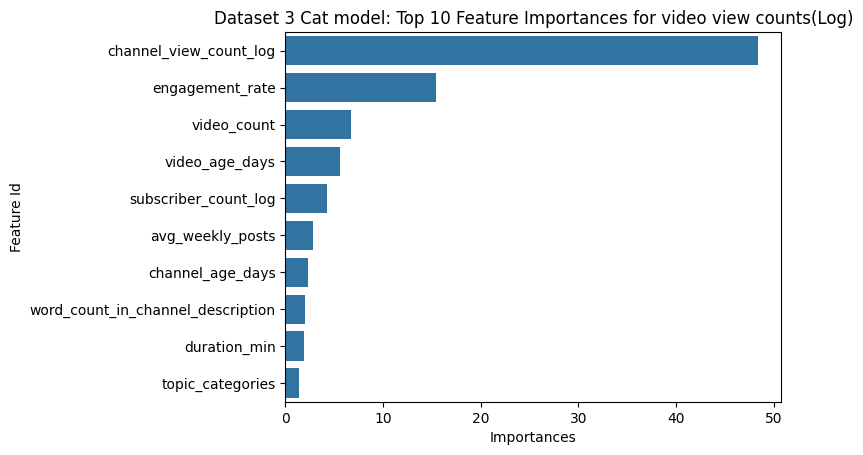

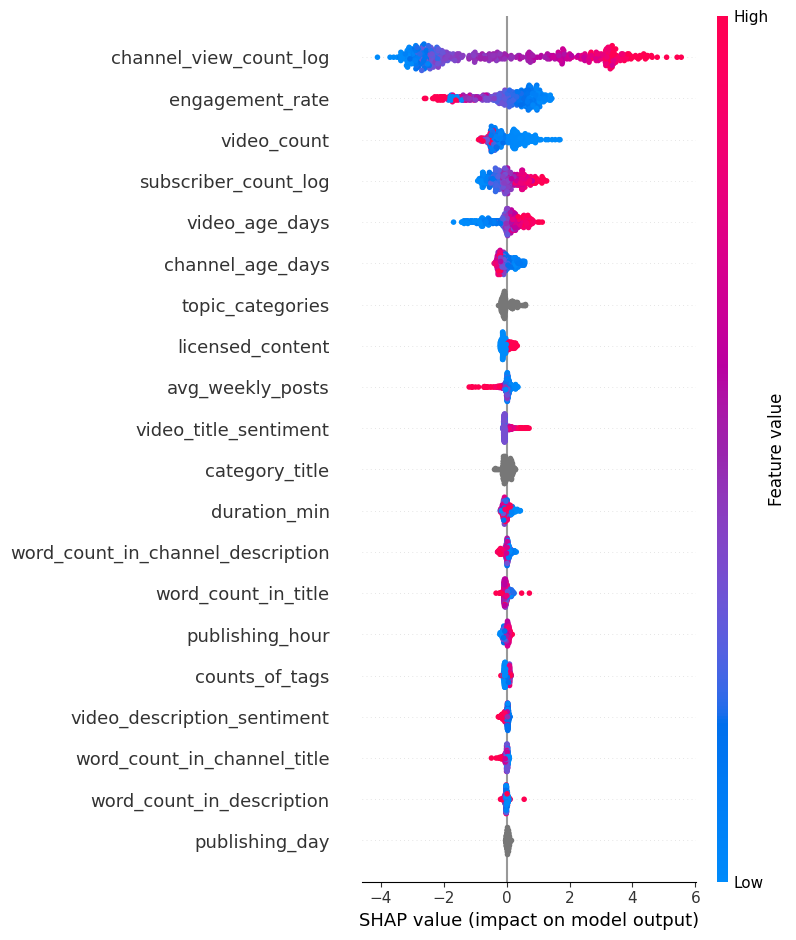

In [161]:
train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_cols)
test_pool = Pool(data=X_test, label=y_test,cat_features=categorical_cols)
cat_model = CatBoostRegressor(iterations=500,
                             learning_rate=0.05,
                             depth=6,
                             eval_metric='R2',
                             l2_leaf_reg=6, 
                             random_seed=9,
                             logging_level='Silent'
                             )
cat_model.fit(train_pool, eval_set=test_pool, use_best_model=True)
y_pred = cat_model.predict(test_pool)   
r2 = r2_score(y_test, y_pred)
y_pred_real = np.expm1(y_pred)
y_test_real = np.expm1(y_test)
mae = mean_absolute_error(y_test_real, y_pred_real)
mse = mean_squared_error(y_test_real, y_pred_real)
rmse = np.sqrt(mse) 
print(f'R^2: {r2}')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')  


feature_importance_df = cat_model.get_feature_importance(prettified=True)
feature_importance_df
feature_importance_df = feature_importance_df.sort_values(by='Importances', ascending=False)
sns.barplot(x='Importances', y='Feature Id', data=feature_importance_df.head(10) )
plt.title('Dataset 3 Cat model: Top 10 Feature Importances for video view counts(Log)')
plt.show()

shap_values = cat_model.get_feature_importance(type='ShapValues', data=test_pool)
shap.summary_plot(shap_values[:, :-1], X_test,title='Dataset3: SHAP Feature Importance for Video view counts')  



In [ ]:
# Base model
cat_model = CatBoostRegressor(
    iterations=500,
    eval_metric='R2',
    logging_level='Silent',
    cat_features=categorical_cols,
    random_seed=9
)

# Grid of hyperparameters
param_grid = {
    'depth': [4, 5, 6],
    'learning_rate': [0.01, 0.03, 0.05],
    'l2_leaf_reg': [3, 5, 7, 9],
    
}


r2_scorer = make_scorer(r2_score)

# GridSearchCV
grid_search = GridSearchCV(
    estimator=cat_model,
    param_grid=param_grid,
    cv=3,                
    scoring=r2_scorer,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
train_r2 = best_model.score(X_train, y_train)
test_r2 = best_model.score(X_test, y_test)
print(f"Train R²: {train_r2}")
print(f"Test R²: {test_r2}")

print("Best params:", grid_search.best_params_)
print("Best R^2 (CV):", grid_search.best_score_)

# Predict and reverse log-transform
y_pred_log = grid_search.best_estimator_.predict(X_test)
y_pred = np.expm1(y_pred_log)


from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"MAE: {mae}, RMSE: {rmse}")


Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END .........depth=4, l2_leaf_reg=3, learning_rate=0.03; total time=   0.9s
[CV] END .........depth=4, l2_leaf_reg=3, learning_rate=0.01; total time=   0.9s
[CV] END .........depth=4, l2_leaf_reg=3, learning_rate=0.01; total time=   0.9s
[CV] END .........depth=4, l2_leaf_reg=3, learning_rate=0.03; total time=   0.9s
[CV] END .........depth=4, l2_leaf_reg=3, learning_rate=0.01; total time=   0.9s
[CV] END .........depth=4, l2_leaf_reg=3, learning_rate=0.05; total time=   0.9s
[CV] END .........depth=4, l2_leaf_reg=3, learning_rate=0.03; total time=   1.0s
[CV] END .........depth=4, l2_leaf_reg=3, learning_rate=0.05; total time=   1.0s
[CV] END .........depth=4, l2_leaf_reg=5, learning_rate=0.01; total time=   0.8s
[CV] END .........depth=4, l2_leaf_reg=3, learning_rate=0.05; total time=   0.9s
[CV] END .........depth=4, l2_leaf_reg=5, learning_rate=0.03; total time=   0.8s
[CV] END .........depth=4, l2_leaf_reg=5, learn

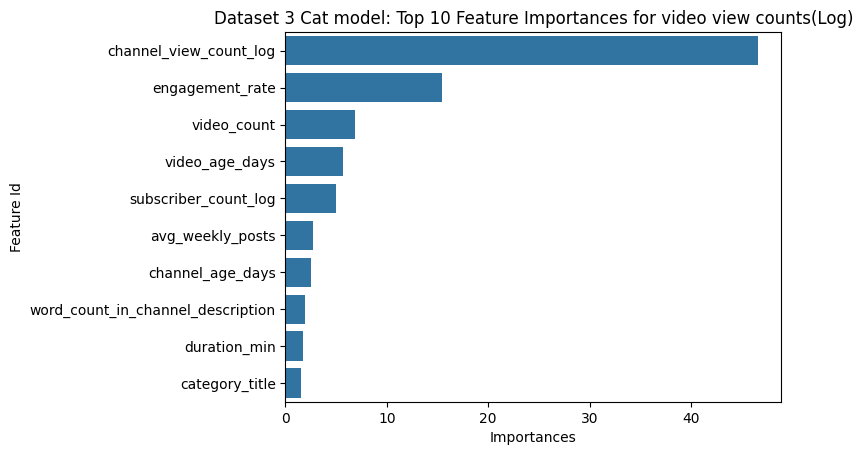

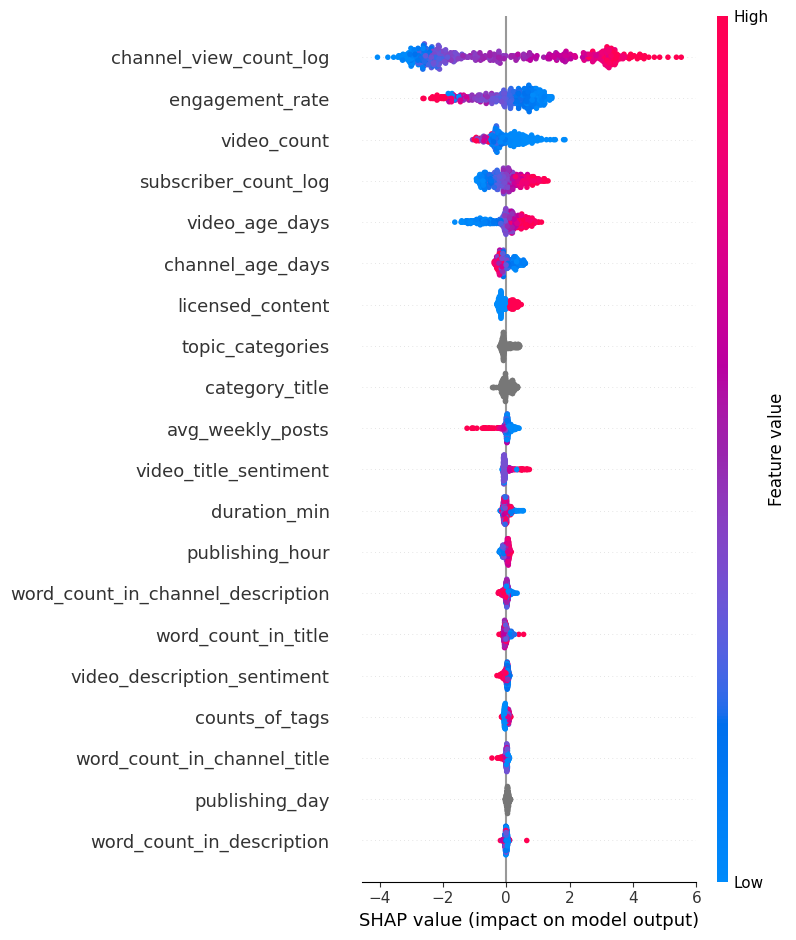

Exception ignored in: <function ResourceTracker.__del__ at 0x1069a9da0>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x107841da0>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/m

In [ ]:
feature_importance_df = best_model.get_feature_importance(prettified=True)
feature_importance_df
feature_importance_df = feature_importance_df.sort_values(by='Importances', ascending=False)
sns.barplot(x='Importances', y='Feature Id', data=feature_importance_df.head(10) )
plt.title('Dataset 3 Cat model: Top 10 Feature Importances for video view counts(Log)')
plt.show()

shap_values = best_model.get_feature_importance(type='ShapValues', data=test_pool)
shap.summary_plot(shap_values[:, :-1], X_test,title='Dataset3: SHAP Feature Importance for Video view counts')  


In [167]:
print(feature_importance_df)

                             Feature Id  Importances
0                channel_view_count_log    46.597181
1                       engagement_rate    15.435309
2                           video_count     6.884415
3                        video_age_days     5.677919
4                  subscriber_count_log     5.036524
5                      avg_weekly_posts     2.748529
6                      channel_age_days     2.485802
7     word_count_in_channel_description     1.929927
8                          duration_min     1.739081
9                        category_title     1.499260
10                     topic_categories     1.351921
11                     licensed_content     1.094574
12                video_title_sentiment     1.048156
13                  word_count_in_title     0.940680
14          video_description_sentiment     0.903575
15                      publishing_hour     0.892182
16            word_count_in_description     0.836471
17                       counts_of_tags     0.

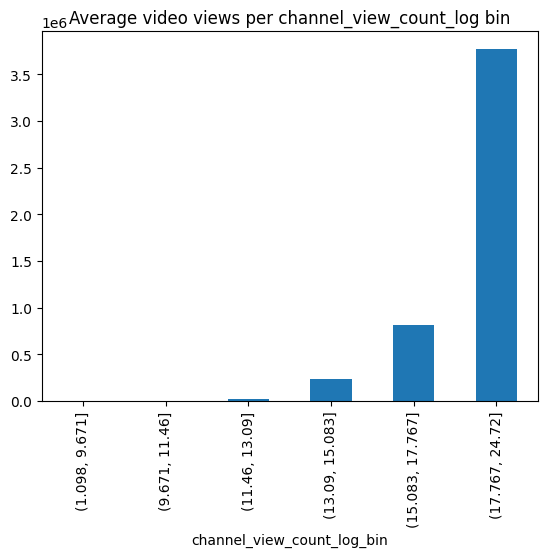

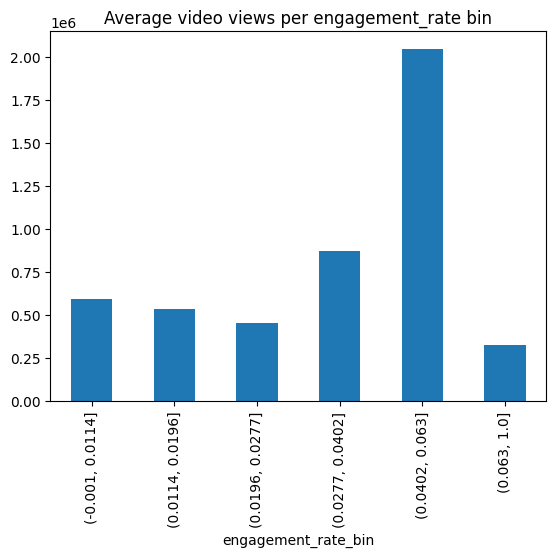

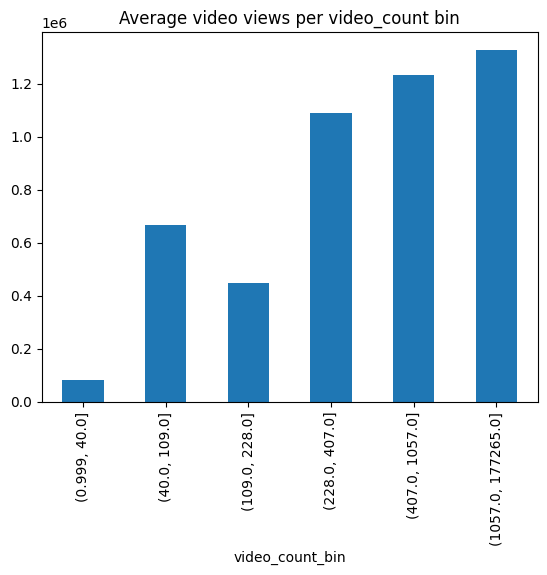

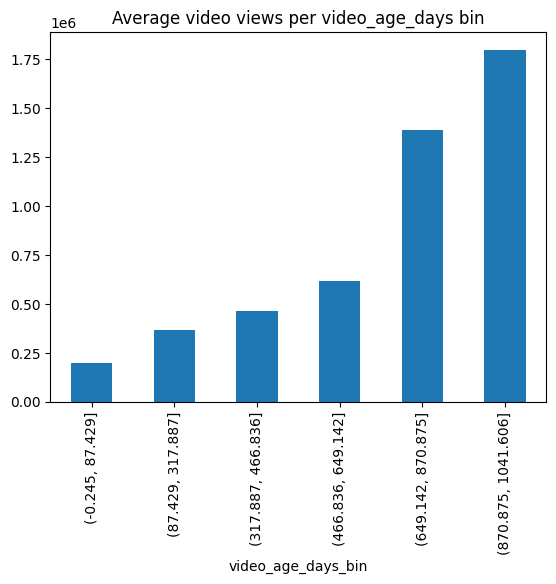

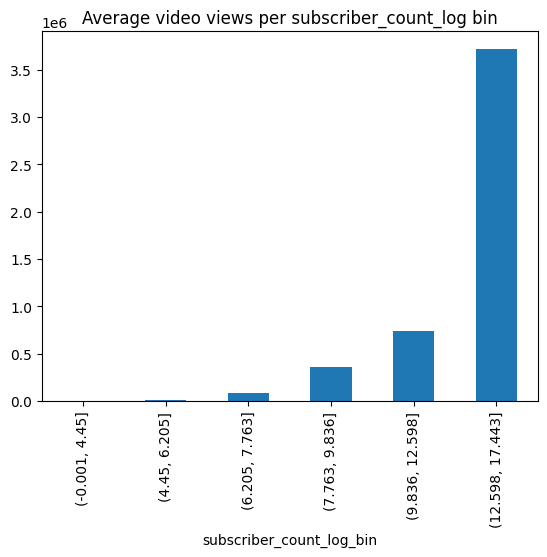

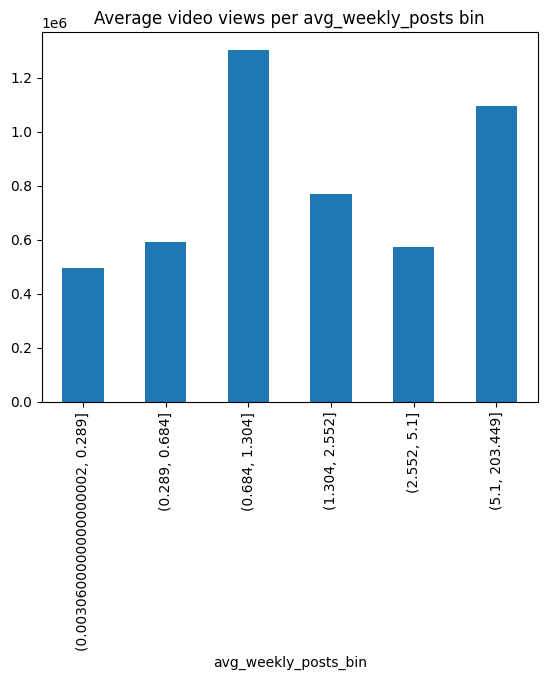

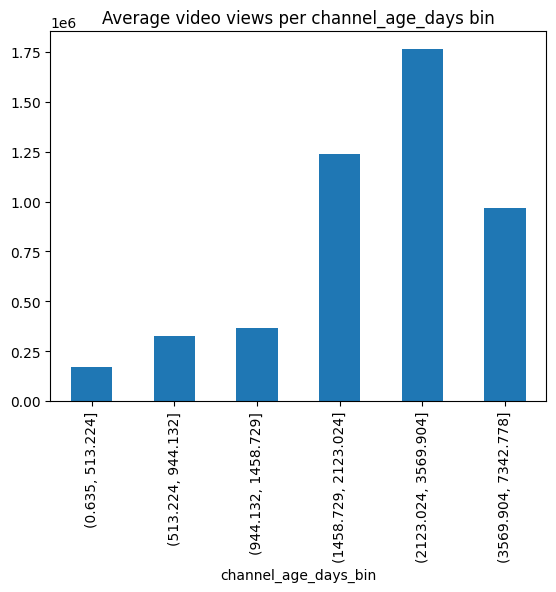

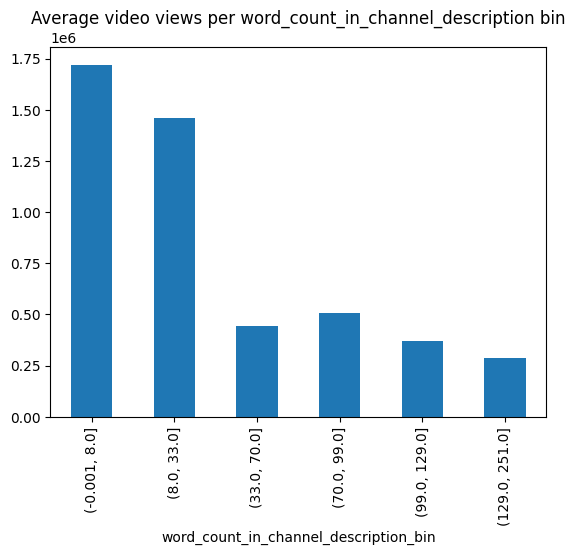

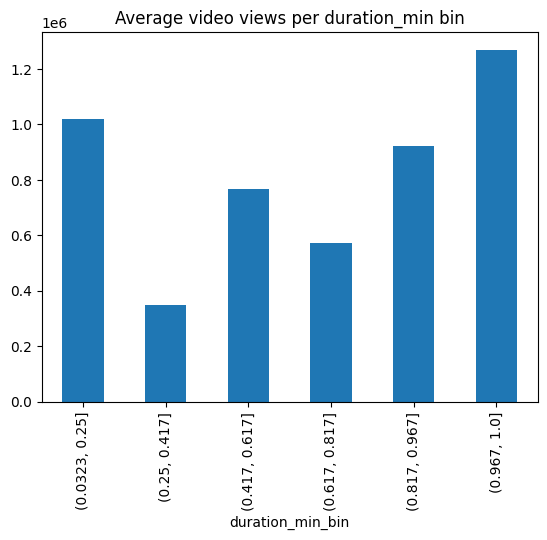

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [169]:
for feature in feature_importance_df['Feature Id'].head(10):
    df[f'{feature}_bin'] = pd.qcut(df[feature], q=6, duplicates='drop' )  # 5 quantiles
    df.groupby(f'{feature}_bin')['video_view_count'].mean().plot(kind='bar')
    plt.title(f"Average video views per {feature} bin")
    plt.show()

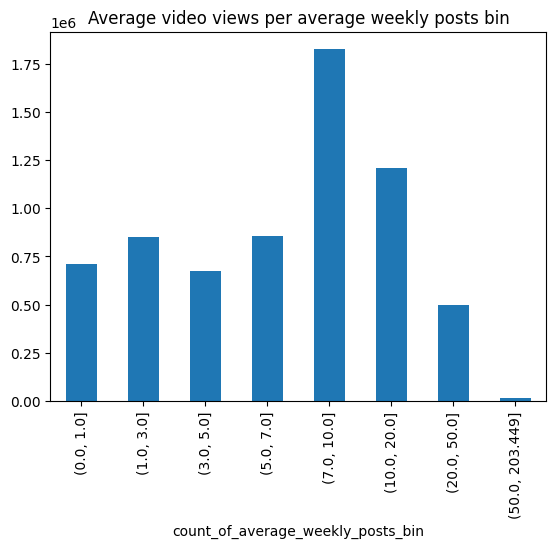

In [172]:
bins = [0,1,3,5,7,10,20,50,df['avg_weekly_posts'].max()]
df['count_of_average_weekly_posts_bin'] = pd.cut(df['avg_weekly_posts'], bins=bins)
df.groupby('count_of_average_weekly_posts_bin')['video_view_count'].mean().plot(kind='bar')
plt.title("Average video views per average weekly posts bin")
plt.show()  

In [146]:
df['relative_video_views'] = df['video_view_count'] / (df['channel_view_count']/df['video_count'])
df['relative_video_views'].describe()
threshold = df['relative_video_views'].quantile(0.8)

df_high_rel_views = df[(df['relative_video_views']>threshold)]
df_high_rel_views.info()

<class 'pandas.core.frame.DataFrame'>
Index: 431 entries, 3 to 2400
Data columns (total 49 columns):
 #   Column                               Non-Null Count  Dtype              
---  ------                               --------------  -----              
 0   fetching_date                        431 non-null    datetime64[ns]     
 1   trending_country                     431 non-null    object             
 2   video_id                             431 non-null    object             
 3   video_title                          431 non-null    object             
 4   video_published_at                   431 non-null    datetime64[ns, UTC]
 5   video_description                    431 non-null    object             
 6   channel_id                           431 non-null    object             
 7   channel_title                        431 non-null    object             
 8   tags                                 431 non-null    object             
 9   category_id                         

In [139]:
df_high_rel_views.describe()

,fetching_date,category_id,video_view_count,video_like_count,video_comment_count,duration_min,channel_view_count,subscriber_count,video_count,video_title_sentiment,...,word_count_in_channel_title,word_count_in_channel_description,engagement_rate,avg_weekly_posts,video_view_count_log,video_like_count_log,video_comment_count_log,channel_view_count_log,subscriber_count_log,relative_video_views
count,430,430.000000,4.300000e+02,4.300000e+02,430.000000,430.000000,4.300000e+02,4.300000e+02,430.000000,430.000000,...,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000
mean,2025-11-09 10:47:38.100173568,25.888372,2.559542e+06,7.818613e+04,516.816279,0.554341,7.803688e+07,5.395791e+05,959.116279,0.087602,...,2.093023,69.120930,0.024954,2.976637,12.698903,8.812515,4.044387,15.100710,9.632668,36.213169
min,2025-11-09 10:47:38.100173,1.000000,1.232000e+03,4.000000e+00,0.000000,0.066667,3.210000e+02,0.000000e+00,5.000000,-0.928400,...,1.000000,0.000000,0.002154,0.037623,7.117206,1.609438,0.000000,5.774552,0.000000,9.350581
25%,2025-11-09 10:47:38.100173056,27.000000,9.725125e+04,1.728000e+03,12.000000,0.233333,5.339975e+05,1.980000e+03,102.250000,0.000000,...,1.000000,19.000000,0.013820,0.555888,11.485036,7.455286,2.564949,13.188131,7.591206,14.781928
50%,2025-11-09 10:47:38.100173056,27.000000,3.725480e+05,7.128500e+03,57.000000,0.550000,3.156628e+06,1.335000e+04,305.500000,0.000000,...,2.000000,72.000000,0.022102,1.618880,12.828114,8.871968,4.060443,14.965015,9.499283,25.263265
75%,2025-11-09 10:47:38.100173056,27.000000,9.547612e+05,2.595350e+04,216.000000,0.900000,2.286820e+07,1.190000e+05,907.000000,0.177900,...,3.000000,113.000000,0.034111,3.598973,13.769167,10.164037,5.379865,16.945258,11.686887,48.990875
max,2025-11-09 10:47:38.100173,28.000000,1.549867e+08,6.436432e+06,43119.000000,1.000000,7.080770e+09,1.240000e+07,10674.000000,0.900100,...,6.000000,173.000000,0.078079,55.000718,18.858850,15.677485,10.671742,22.680649,16.333207,125.044005
std,NaN,2.983498,1.239506e+07,4.289578e+05,2650.243334,0.326679,4.055638e+08,1.889206e+06,1915.187471,0.273136,...,0.992136,49.585501,0.014275,4.598595,1.924145,2.159796,2.042437,2.622181,2.884748,27.983377


In [147]:
df_model2 = df_high_rel_views[[ 'licensed_content',  'topic_categories',
       'made_for_kids', 'duration_min', 'video_count', 'category_title',
       'video_title_sentiment', 'count_of_emoji_in_video_title',
       'video_description_sentiment', 'count_of_emoji_in_video_description',
       'publishing_day', 'publishing_hour', 'video_age_days',
        'counts_of_tags', 'word_count_in_title',
       'word_count_in_description','engagement_rate',
        'video_view_count_log',
       'video_like_count_log', 'video_comment_count_log',
       ]]
len(df_model.columns)

23

In [143]:
df_model2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 430 entries, 3 to 2392
Data columns (total 20 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   licensed_content                     430 non-null    bool   
 1   topic_categories                     430 non-null    object 
 2   made_for_kids                        430 non-null    bool   
 3   duration_min                         430 non-null    float64
 4   video_count                          430 non-null    int64  
 5   category_title                       430 non-null    object 
 6   video_title_sentiment                430 non-null    float64
 7   count_of_emoji_in_video_title        430 non-null    int64  
 8   video_description_sentiment          430 non-null    float64
 9   count_of_emoji_in_video_description  430 non-null    int64  
 10  publishing_day                       430 non-null    object 
 11  publishing_hour                     

In [148]:
X = df_model2.drop(columns= ['video_view_count_log','video_like_count_log', 'video_comment_count_log'])
y = df_high_rel_views['video_view_count_log']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9, shuffle=True)


In [133]:
X_train.columns

Index(['licensed_content', 'topic_categories', 'made_for_kids', 'duration_min',
       'video_count', 'category_title', 'video_title_sentiment',
       'count_of_emoji_in_video_title', 'video_description_sentiment',
       'count_of_emoji_in_video_description', 'publishing_day',
       'publishing_hour', 'video_age_days', 'counts_of_tags',
       'word_count_in_title', 'word_count_in_description', 'engagement_rate'],
      dtype='object')

R^2: 0.32432068335396147
MAE: 3131911.5873452295
MSE: 289000267288919.0
RMSE: 17000007.861436978


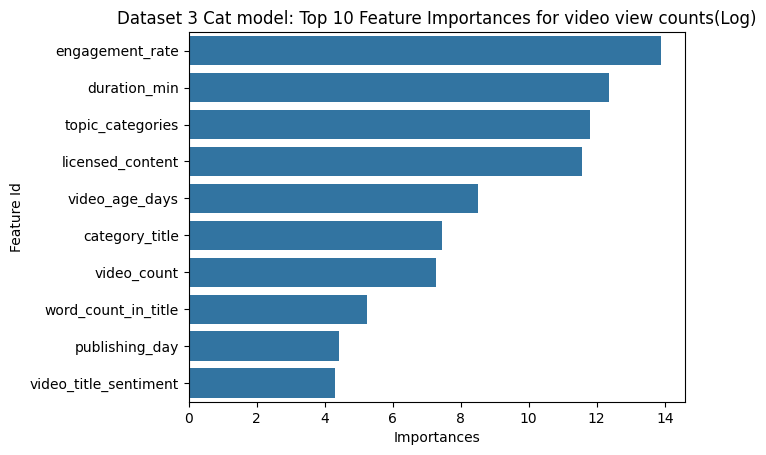

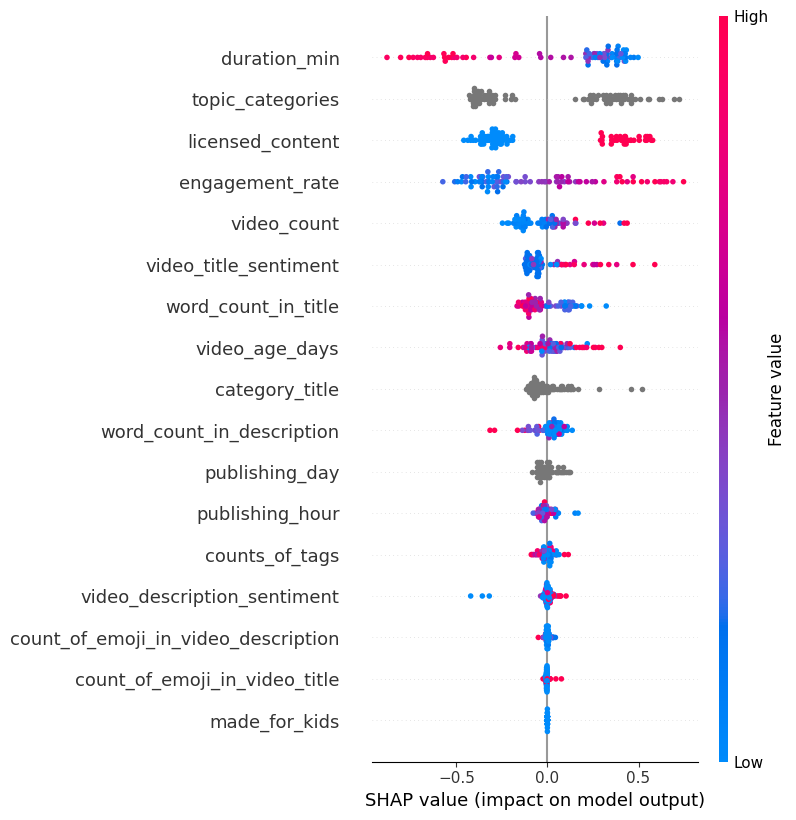

In [149]:
train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_cols)
test_pool = Pool(data=X_test, label=y_test,cat_features=categorical_cols)
cat_model = CatBoostRegressor(iterations=1000,
                             learning_rate=0.05,
                             depth=6,
                             eval_metric='R2',
                             l2_leaf_reg=5, 
                             random_seed=9,
                             logging_level='Silent'
                             )
cat_model.fit(train_pool, eval_set=test_pool, use_best_model=True)
y_pred = cat_model.predict(test_pool)   
r2 = r2_score(y_test, y_pred)
y_pred_real = np.expm1(y_pred)
y_test_real = np.expm1(y_test)
mae = mean_absolute_error(y_test_real, y_pred_real)
mse = mean_squared_error(y_test_real, y_pred_real)

rmse = np.sqrt(mse) 
print(f'R^2: {r2}')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')  


feature_importance_df = cat_model.get_feature_importance(prettified=True)
feature_importance_df
feature_importance_df = feature_importance_df.sort_values(by='Importances', ascending=False)
sns.barplot(x='Importances', y='Feature Id', data=feature_importance_df.head(10) )
plt.title('Dataset 3 Cat model: Top 10 Feature Importances for video view counts(Log)')
plt.show()

shap_values = cat_model.get_feature_importance(type='ShapValues', data=test_pool)
shap.summary_plot(shap_values[:, :-1], X_test,title='Dataset3: SHAP Feature Importance for Video view counts')  



In [ ]:
df[pd.to_datetime(df['video_published_at']).dt.year == 2025]['game' in df['video_title']].sort_values('video_view_count', ascending=False)[['video_title', 'video_view_count', 'video_id']].head(50)

,video_title,video_view_count,video_id
662,from human to black hole blackhole quantumphys...,56911478.0,E2Dg58AUcWA
1889,the evolution of computers,25100656.0,eQRpBT85gcg
2478,i asked cursor to fix a small bug coding with ...,8627757.0,riflxxpE-Cg
152,finally india begins compulsory ai education i...,6526372.0,2MPh3FDq5Pc
701,coding decoding reasoning important notes reas...,6289629.0,EozTGe8W4Ac
641,the reticulated python is a big nope rope,5316303.0,DTTgjwD22J8
1233,catching a python can even cost your life shor...,5063233.0,QL52_ksoJeo
66,senior python developer with 30 years of exper...,3253243.0,0Y82opjHbPA
841,series 1 not todaypython shorts rescue wildlif...,3224839.0,HiGY8Gdpt1g
2261,selectionway new office selectionway gagan pra...,3160012.0,mfvFht1Vyc4


In [ ]:
df[
    (pd.to_datetime(df['video_published_at']).dt.year == 2025) &
    (df['video_description'].str.contains('game', case=False, na=False))
].sort_values('video_view_count', ascending=False)[
    ['video_title', 'video_view_count', 'video_id']
].head(50)

,video_title,video_view_count,video_id
2367,top 5 software engineering project ideas for c...,464244.0,pDtYMfpfir0
1878,programmer fails at codingupsc topperupsc inte...,287175.0,eH9l4olSeGI
43,build a rock paper scissors game with html css...,221637.0,0EQjoRLe1EU
1735,build 3d games in minutes with free ai ai does...,150894.0,bLd_7GiOUIg
1640,learn python with fun cartoons python basics f...,85816.0,_3Evgblmfwo
1176,ai built this 3d car game in minutes html css ...,58679.0,OronVCDU0F8
1656,gpt5 next level coding ai chatgpt,5783.0,_QNQWmU_BLU
1344,50 saal purani coding secretcoding bca capcut,4628.0,TD_lHUV8pD4
1766,8100 coding Number Star Patternlogic building ...,2014.0,bv4vGxJufG4
38,python animation pygame python tutorial python...,1994.0,00d56VaM78s
